# Imports

In [194]:
import numpy as np
from skimage import io

# Parameters

In [195]:
# angle diff between iterations
EMITTER_STEP = 1
# n
DETECTOR_COUNT = 100
# I (deg)
DETECTOR_SPAN = 180

# input and output file
INPUT_PATH = "imgs/Shepp_logan.jpg"
OUTPUT_PATH = "ct_output.jpg"

# Functions

In [196]:
def normalize_img(img):
    """values in range 0-1"""
    min_v = np.amin(img)
    max_v = np.amax(img)
    if min_v != max_v:
        return (img[:, :] - min_v) / (max_v - min_v)
    return img

In [197]:
def resize_to_square(img):
    #size = int(np.ceil(np.max(img.shape) * np.sqrt(2)))
    size = np.max(img.shape)
    size += 1 - size % 2
    square_img = np.zeros((size, size))
    dy, dx = (size - img.shape[0]) // 2, (size - img.shape[1]) // 2
    square_img[dy:(img.shape[0] + dy), dx:(img.shape[1] + dx)] = img
    return square_img

In [198]:
def load_img(path):
    img = io.imread(path, as_gray=True)
    img = normalize_img(img)
    img = resize_to_square(img)
    return img

In [199]:
def show_img(img):
    io.imshow(img, cmap='gray')

In [200]:
def bresenham(x0, y0, x1, y1):
    """generator yielding tuples of xs and ys of pixels traversed on line from (x0, y0) to (x1, y1) (inclusive)"""
    def delta_and_sign(v0, v1):
        return (v1 - v0, 1) if v0 < v1 else (v0 - v1, -1)
    
    dx, x_sign = delta_and_sign(x0, x1)
    dy, y_sign = delta_and_sign(y0, y1)
    
    x, y = x0, y0
    yield x, y
    if dx > dy:
        ai = 2 * (dy - dx)
        bi = dy * 2
        d = bi - dx
        while x != x1:
            if d >= 0:
                y += y_sign
                d += ai
            else:
                d += bi;
            x += x_sign
            yield x, y
    else:
        ai = 2 * (dx - dy)
        bi = dx * 2
        d = bi - dy;
        while y != y1:
            if d >= 0:
                x += x_sign
                d += ai
            else:
                d += bi
            y += y_sign
            yield x, y

In [201]:
def bresenham_list(x0, y0, x1, y1):
    """list of points from bresenham generator"""
    return [*bresenham(x0, y0, x1, y1)]

In [202]:
def points_to_indices(points):
    """points to indices for np.array"""
    return tuple([*zip(*points)][::-1])

In [203]:
def mean_on_line(img, x0, y0, x1, y1):
    """mean of pixels on line from (x0, y0) to (x1, y1) (inclusive)"""
    return np.mean(img[points_to_indices(bresenham_list(x0, y0, x1, y1))])

In [204]:
def calc_radius(img):
    """assume img is already square"""
    r = img.shape[0] // 2
    return r

In [205]:
def rad_to_cart(cx, cy, r, angle):
    """radial to cartesian coordinates conversion, input angle in radians, output x and y truncated ints"""
    x = r * np.cos(angle) + cx
    y = r * np.sin(angle) + cy
    return int(x), int(y)

In [206]:
def emitter_angles(emitter_step, r):
    return np.arange(0, np.pi, emitter_step)

In [207]:
def detectors(r, emitter_angle, detector_count, detector_span):
    """generate detectors based on emitter coordinates, angles in radians"""
    detector_angle = emitter_angle + np.pi - detector_span / 2.0
    if detector_angle < 0:
        detector_angle += 2 * np.pi
    elif detector_angle >= 2 * np.pi:
        detector_angle -= 2 * np.pi
        
    angle_diff = detector_span / detector_count
    for i in range(detector_count):
        x, y = rad_to_cart(r, r, r, detector_angle)
        detector_angle += angle_diff
        yield x, y

In [208]:
def lines(r, emitter_angle, detector_count, detector_span):
    """generate lines between emitters and detectors (parallel)"""
    half_span = detector_span / 2.0
    emitter_from = emitter_angle + half_span
    emitter_to = emitter_from - detector_span
    detector_from = emitter_angle + np.pi - half_span
    detector_to = detector_from + detector_span
    
    emitter_angles = np.linspace(emitter_from, emitter_to, detector_count)
    detector_angles = np.linspace(detector_from, detector_to, detector_count)
    for em_angle, det_angle in zip(emitter_angles, detector_angles):
        ex, ey = rad_to_cart(r, r, r, em_angle)
        dx, dy = rad_to_cart(r, r, r, det_angle)
        yield ex, ey, dx, dy

In [209]:
def emitter_measurements(img, r, emitter_angle, detector_count, detector_span):
    #emitter_pos = rad_to_cart(r, r, r, emitter_angle)
    measurements = np.zeros(detector_count)
    #for i, detector_pos in enumerate(detectors(r, emitter_angle, detector_count, detector_span)):
    #    measurements[i] = mean_on_line(img, *emitter_pos, *detector_pos)
    for i, line in enumerate(lines(r, emitter_angle, detector_count, detector_span)):
        measurements[i] = mean_on_line(img, *line)
    return measurements

In [210]:
def img_to_sinogram(img, emitter_step, r, detector_count, detector_span):
    angles = emitter_angles(emitter_step, r)
    sinogram = np.empty((len(angles), detector_count))
    
    for i, emitter_angle in enumerate(angles):
        sinogram[i, :] = emitter_measurements(img, r, emitter_angle, detector_count, detector_span)
    return sinogram

In [211]:
def emitter_onto_img(img, measurments, r, emitter_angle, detector_count, detector_span):
    #emitter_pos = rad_to_cart(r, r, r, emitter_angle)
    #for i, detector_pos in enumerate(detectors(r, emitter_angle, detector_count, detector_span)):
        #img[points_to_indices(bresenham_list(*emitter_pos, *detector_pos))] += measurments[i]
    for i, line in enumerate(lines(r, emitter_angle, detector_count, detector_span)):
        img[points_to_indices(bresenham_list(*line))] += measurments[i]

In [212]:
def sinogram_to_img(sinogram, emitter_step, r, detector_count, detector_span):
    img = np.zeros((2 * r + 1, 2 * r + 1))
    
    for i, emitter_angle in enumerate(emitter_angles(emitter_step, r)):
        emitter_onto_img(img, sinogram[i, :], r, emitter_angle, detector_count, detector_span)
    return img

# App

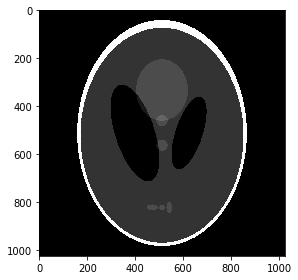

In [213]:
# load img
input_image = load_img(INPUT_PATH)
show_img(input_image)

# calculate params
r = calc_radius(input_image)
emitter_step_rad = np.deg2rad(EMITTER_STEP)
detector_span_rad = np.deg2rad(DETECTOR_SPAN)

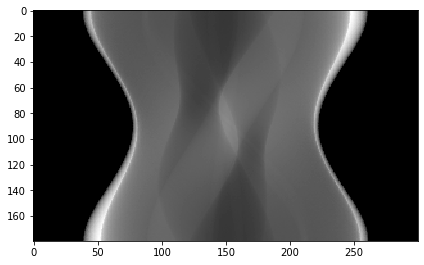

In [214]:
# get sinogram
sinogram = img_to_sinogram(input_image, emitter_step_rad, r, DETECTOR_COUNT, detector_span_rad)
show_img(normalize_img(sinogram))

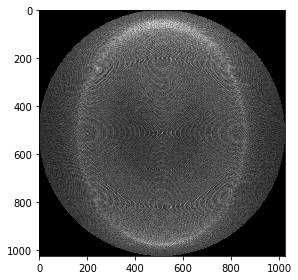

In [215]:
output_img = sinogram_to_img(sinogram, emitter_step_rad, r, DETECTOR_COUNT, detector_span_rad)
show_img(normalize_img(output_img))